# Preprocessing and clustering 3k PBMCs

In May 2017, this started out as a demonstration that Scanpy would allow to reproduce most of Seurat's [guided clustering tutorial](http://satijalab.org/seurat/pbmc3k_tutorial.html) ([Satija et al., 2015](https://doi.org/10.1038/nbt.3192)).

We gratefully acknowledge Seurat's authors for the tutorial! In the meanwhile, we have added and removed a few pieces.

The data consist of *3k PBMCs from a Healthy Donor* and are freely available from 10x Genomics ([here](http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz) from this [webpage](https://support.10xgenomics.com/single-cell-gene-expression/datasets/1.1.0/pbmc3k)). On a unix system, you can uncomment and run the following to download and unpack the data. The last line creates a directory for writing processed data.

In [2]:
# !mkdir data
# !wget http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz -O data/pbmc3k_filtered_gene_bc_matrices.tar.gz
# !cd data; tar -xzf pbmc3k_filtered_gene_bc_matrices.tar.gz
# !mkdir write

:::{note}
Download the notebook by clicking on the _Edit on GitHub_ button. On GitHub, you can download using the _Raw_ button via right-click and _Save Link As_. Alternatively, download the whole [scanpy-tutorial](https://github.com/theislab/scanpy-tutorials) repository.
:::

:::{note}
In Jupyter notebooks and lab, you can see the documentation for a python function by hitting ``SHIFT + TAB``. Hit it twice to expand the view.
:::

In [3]:
import numpy as np
import pandas as pd
import scanpy as sc

In [4]:
import matplotlib.pyplot as plt

# def. the default font sizes, makes graph much nicer
plt.rc('font', size=12)
plt.rc('axes', labelsize=12, titlesize=12)
plt.rc('legend', fontsize=12)
plt.rc('xtick', labelsize=8)
plt.rc('ytick', labelsize=8)

plt.style.use('seaborn-whitegrid')

/var/folders/ld/lzj7sybn12d9khvdm4qgtcq40000gn/T/ipykernel_14621/3589025435.py:10: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


In [5]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

/Users/yinglin/opt/anaconda3/envs/sc1/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


scanpy==1.9.3 anndata==0.9.1 umap==0.5.3 numpy==1.23.5 scipy==1.10.1 pandas==2.0.1 scikit-learn==1.2.2 statsmodels==0.14.0 python-igraph==0.10.4 louvain==0.8.0 pynndescent==0.5.10


In [6]:
results_file = 'write/pbmc3k.h5ad'  # the file that will store the analysis results

Read in the count matrix into an [AnnData](https://anndata.readthedocs.io/en/latest/anndata.AnnData.html) object, which holds many slots for annotations and different representations of the data. It also comes with its own HDF5-based file format: `.h5ad`.

In [7]:
adata = sc.read_10x_mtx(
    'filtered_gene_bc_matrices/hg19/',  # the directory with the `.mtx` file
    var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)
    cache=True)                              # write a cache file for faster subsequent reading

... reading from cache file cache/filtered_gene_bc_matrices-hg19-matrix.h5ad


:::{note}
See [anndata-tutorials/getting-started](https://anndata-tutorials.readthedocs.io/en/latest/getting-started.html) for a more comprehensive introduction to `AnnData`.
:::

In [8]:
adata.var_names_make_unique()  # this is unnecessary if using `var_names='gene_ids'` in `sc.read_10x_mtx`

In [9]:
adata

AnnData object with n_obs × n_vars = 2700 × 32738
    var: 'gene_ids'

## Preprocessing

Show those genes that yield the highest fraction of counts in each single cell, across all cells.

normalizing counts per cell
    finished (0:00:00)


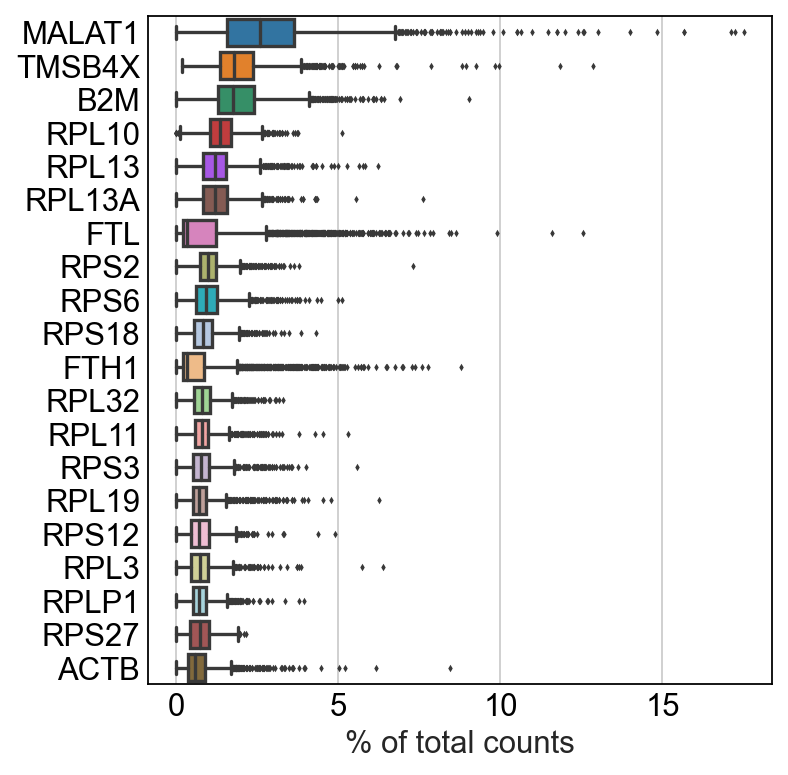

In [10]:
sc.pl.highest_expr_genes(adata, n_top=20, )

Basic filtering:

In [11]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

filtered out 19024 genes that are detected in less than 3 cells


Let's assemble some information about mitochondrial genes, which are important for quality control.

Citing from "Simple Single Cell" workflows [(Lun, McCarthy & Marioni, 2017)](https://master.bioconductor.org/packages/release/workflows/html/simpleSingleCell.html#examining-gene-level-metrics):

> High proportions are indicative of poor-quality cells (Islam et al. 2014; Ilicic et al. 2016), possibly because of loss of cytoplasmic RNA from perforated cells. The reasoning is that mitochondria are larger than individual transcript molecules and less likely to escape through tears in the cell membrane.

With `pp.calculate_qc_metrics`, we can compute many metrics very efficiently.

In [12]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

A violin plot of some of the computed quality measures:

* the number of genes expressed in the count matrix
* the total counts per cell
* the percentage of counts in mitochondrial genes

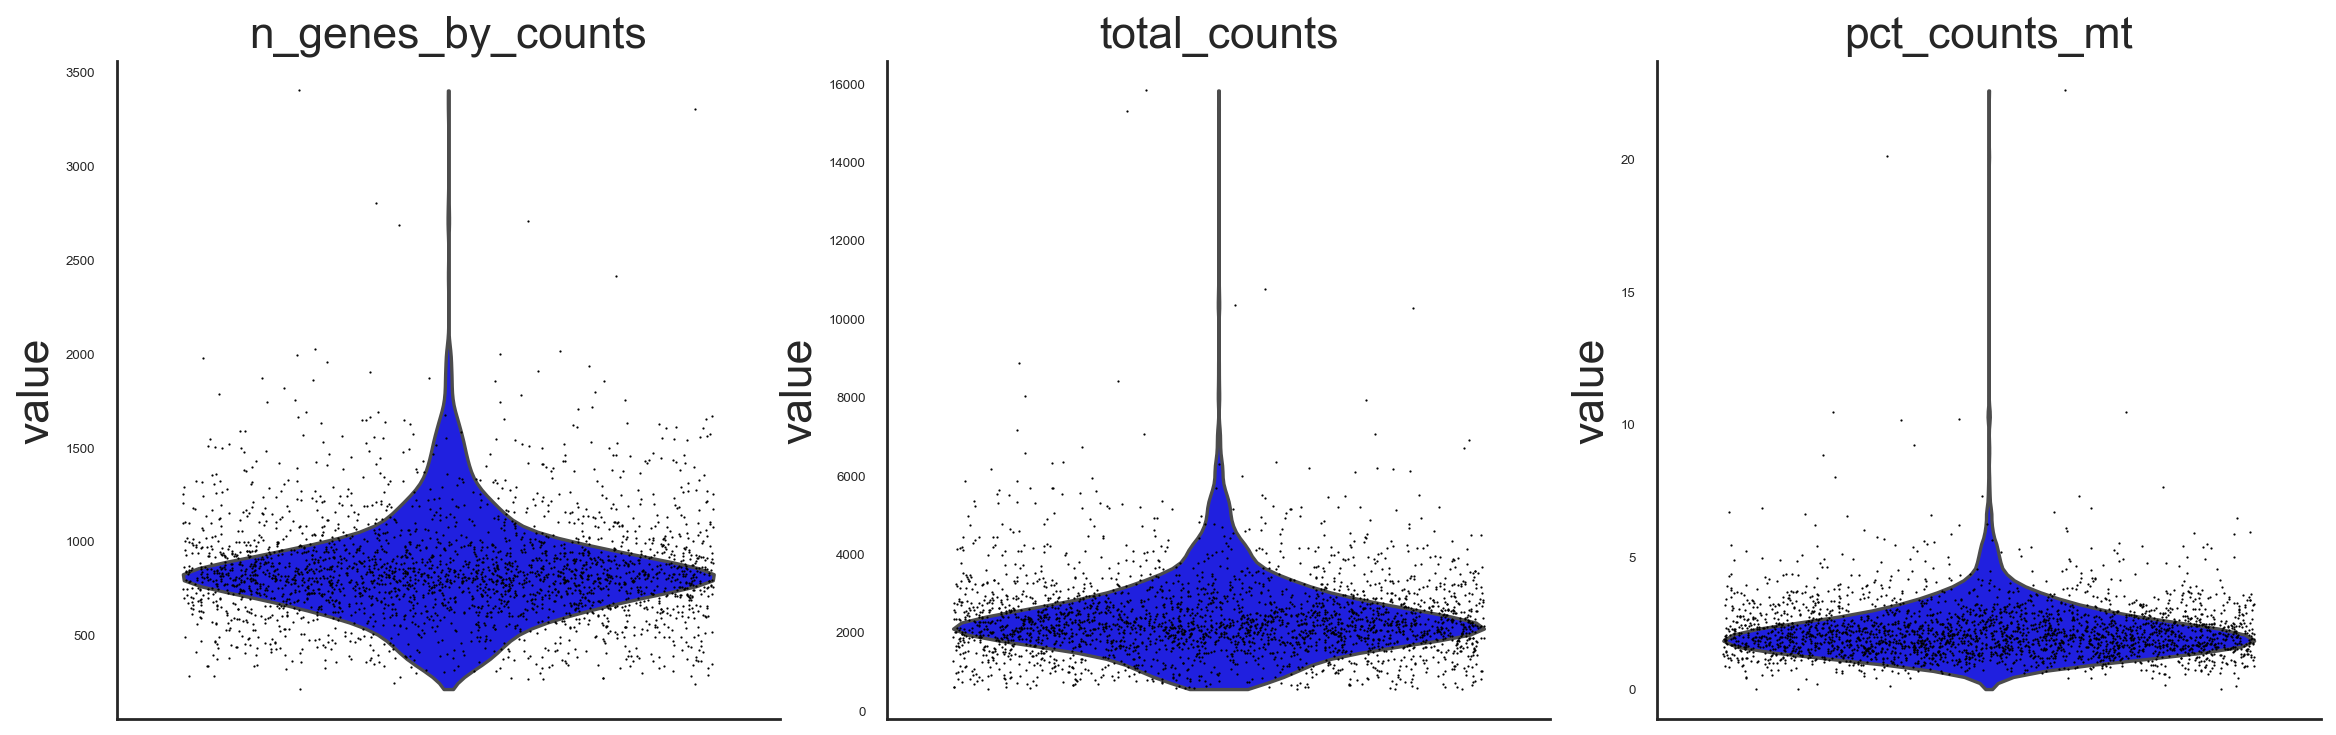

In [48]:
sc.pl.violin(adata, 
             ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4,
             multi_panel=True, 
             color='blue',
             save='violin_gene_totol_pct.png')

Violin:
box plot
kernel density plots

A violin plot is a data visualization method that combines aspects of box plots and kernel density plots. It is useful for displaying the distribution and summary statistics of a dataset. Here are some characteristics of a good violin plot and reasons why it might be preferred over a standard box plot:

1. **Density Information:** Violin plots provide more information about the data distribution compared to box plots. They include a rotated kernel density plot on each side, giving a sense of the data's underlying distribution.

2. **Summary Statistics:** Similar to box plots, violin plots often include summary statistics such as median, quartiles, and possibly outliers. This makes it easy to grasp key features of the dataset.

3. **Multimodal Distributions:** Violin plots are particularly useful when dealing with multimodal distributions (distributions with multiple peaks). They can reveal the presence of multiple modes, which might be obscured in a box plot.

4. **Comparison Across Categories:** Violin plots can be used to compare the distribution of a variable across different categories. For example, you might compare the gene expression levels in different cell types or conditions.

5. **Visual Appeal:** Violin plots are visually appealing and can be effective in conveying the shape of the distribution. The width of the violin at a specific point indicates the density of data at that value.

Why not use a normal (box) plot?

1. **Simpler Representation:** Box plots provide a simpler representation of the central tendency and spread of the data. If the main goal is a quick summary of the distribution and identification of outliers, a box plot might be more suitable.

2. **Familiarity:** Box plots are widely used and well-understood, making them a familiar choice for many analysts and researchers. In situations where simplicity and familiarity are key, a box plot might be preferred.

3. **Outliers:** Box plots explicitly highlight outliers, making them more suitable when identifying extreme values is crucial.

Ultimately, the choice between a violin plot and a box plot depends on the nature of the data, the information you want to convey, and the preferences of the audience. Both visualization types have their merits, and the best choice often depends on the specific goals of the analysis.

/var/folders/ld/lzj7sybn12d9khvdm4qgtcq40000gn/T/ipykernel_14621/862231968.py:33: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(n_genes_by_counts_values, shade=True, color='skyblue', ax=axs[2])


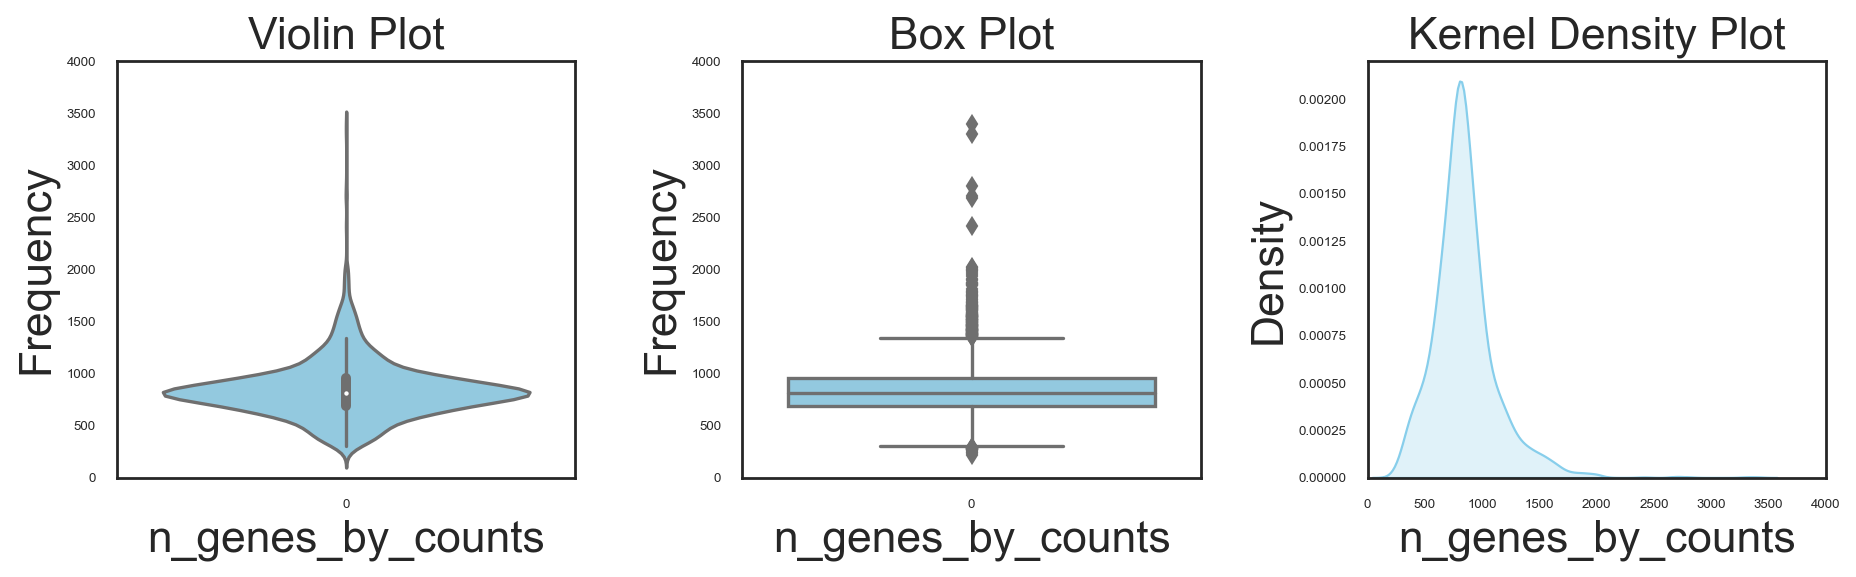

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have n_genes_by_counts_values data

# Set a common figure size for all subplots
common_fig_size = (12, 4)
plt.rc('font', size=20)
plt.rc('axes', labelsize=20, titlesize=20)
plt.rc('legend', fontsize=6)
plt.rc('xtick', labelsize=6)
plt.rc('ytick', labelsize=6)

# Create subplots
fig, axs = plt.subplots(1, 3, figsize=common_fig_size)

# Plot 1: Violin plot
sns.violinplot(n_genes_by_counts_values, color='skyblue', inner='box', ax=axs[0])
axs[0].set_title('Violin Plot')
axs[0].set_xlabel('n_genes_by_counts')
axs[0].set_ylabel('Frequency')
axs[0].set_ylim([0,4000])

# Plot 2: Box plot
sns.boxplot(n_genes_by_counts_values, color='skyblue', ax=axs[1])
axs[1].set_title('Box Plot')
axs[1].set_xlabel('n_genes_by_counts')
axs[1].set_ylabel('Frequency')
axs[1].set_ylim([0,4000])

# Plot 3: Kernel density plot
sns.kdeplot(n_genes_by_counts_values, shade=True, color='skyblue', ax=axs[2])
axs[2].set_title('Kernel Density Plot')
axs[2].set_xlabel('n_genes_by_counts')
axs[2].set_ylabel('Density')
axs[2].set_xlim([0,4000])

plt.tight_layout()  # Adjust layout for better spacing
plt.savefig("panel.png")
plt.show()


## violin, box, and density

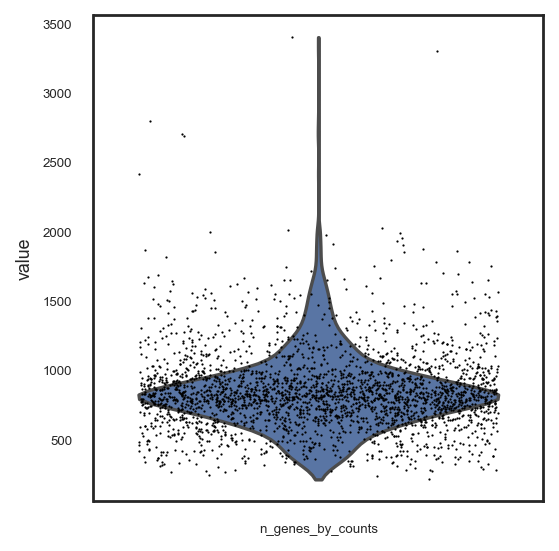

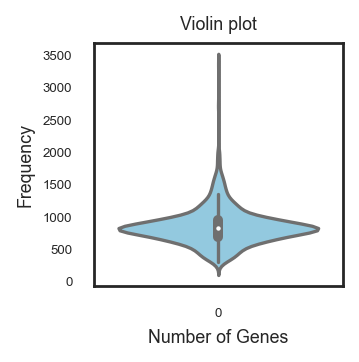

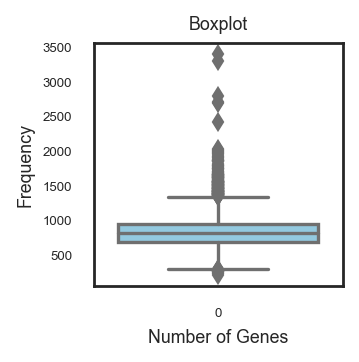

/var/folders/ld/lzj7sybn12d9khvdm4qgtcq40000gn/T/ipykernel_14621/2081710534.py:40: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(n_genes_by_counts_values, shade=True, color='skyblue')


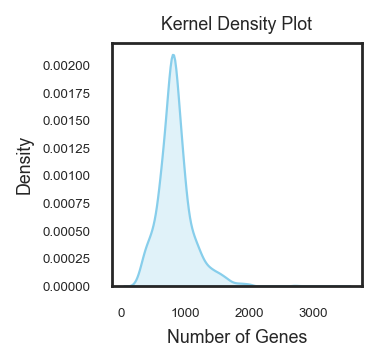

In [26]:
sc.pl.violin(adata, ['n_genes_by_counts'], jitter = 0.4, 
             title='test', save='test.png')

import matplotlib.pyplot as plt
import seaborn as sns  
sns.set_theme(style='white')

# def. the default font sizes, makes graph much nicer
plt.rc('font', size=8)
plt.rc('axes', labelsize=8, titlesize=8)
plt.rc('legend', fontsize=6)
plt.rc('xtick', labelsize=6)
plt.rc('ytick', labelsize=6)

# n_genes_by_counts_values = adata.obs['n_genes_by_counts']
# log_v = np.log(n_genes_by_counts_values)

# Set a common figure size for all plots
common_fig_size = (2, 2)

plt.figure(figsize=common_fig_size)
sns.violinplot(n_genes_by_counts_values, color='skyblue')  # Use kde=True for a kernel density estimate
plt.title('Violin plot')
plt.xlabel('Number of Genes')
plt.ylabel('Frequency')
plt.savefig('violin.png', dpi=300, bbox_inches='tight')
plt.show()

# Create a bar plot
plt.figure(figsize=common_fig_size)
sns.boxplot(n_genes_by_counts_values, color='skyblue')  # Use kde=True for a kernel density estimate
plt.title('Boxplot')
plt.xlabel('Number of Genes')
plt.ylabel('Frequency')
plt.savefig('boxplot.png', dpi=300, bbox_inches='tight')
plt.show()

# Create a kernel density plot
plt.figure(figsize=common_fig_size)
sns.kdeplot(n_genes_by_counts_values, shade=True, color='skyblue')
plt.title('Kernel Density Plot')
plt.xlabel('Number of Genes')
plt.savefig('density.png', dpi=300, bbox_inches='tight')
plt.ylabel('Density')
plt.show()

Remove cells that have too many mitochondrial genes expressed or too many total counts:

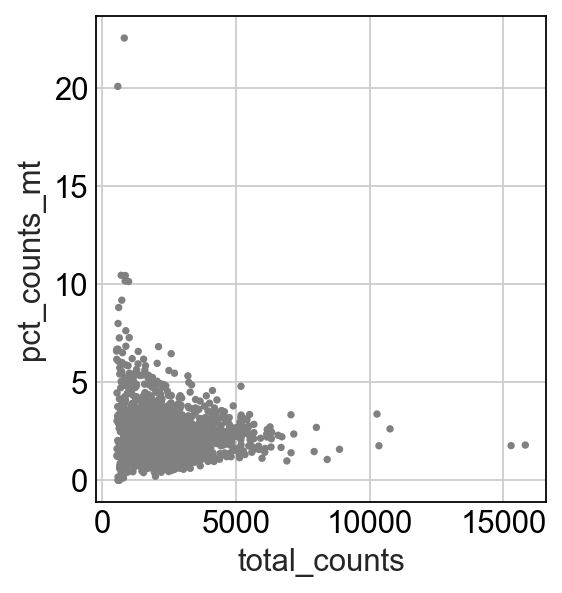

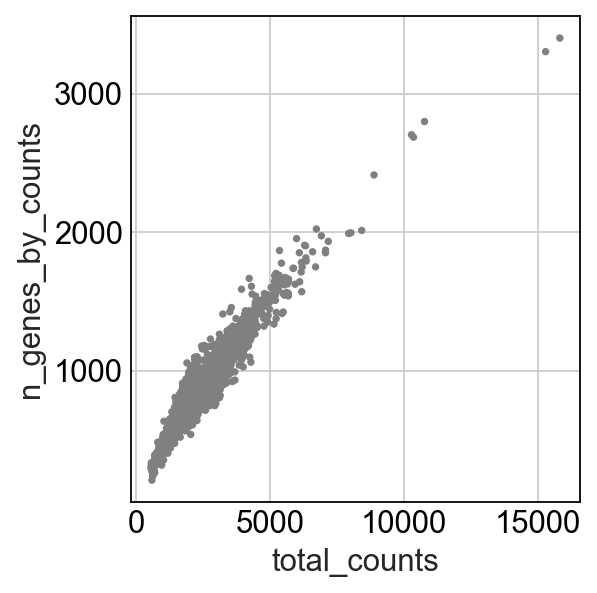

In [15]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

Actually do the filtering by slicing the `AnnData` object.

In [16]:
adata = adata[adata.obs.n_genes_by_counts < 2500, :]
adata = adata[adata.obs.pct_counts_mt < 5, :]

Total-count normalize (library-size correct) the data matrix $\mathbf{X}$ to 10,000 reads per cell, so that counts become comparable among cells.

In [17]:
sc.pp.normalize_total(adata, target_sum=1e4)

normalizing counts per cell
    finished (0:00:00)


/Users/yinglin/opt/anaconda3/envs/sc1/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Logarithmize the data:

In [18]:
sc.pp.log1p(adata)

Identify highly-variable genes.

In [19]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


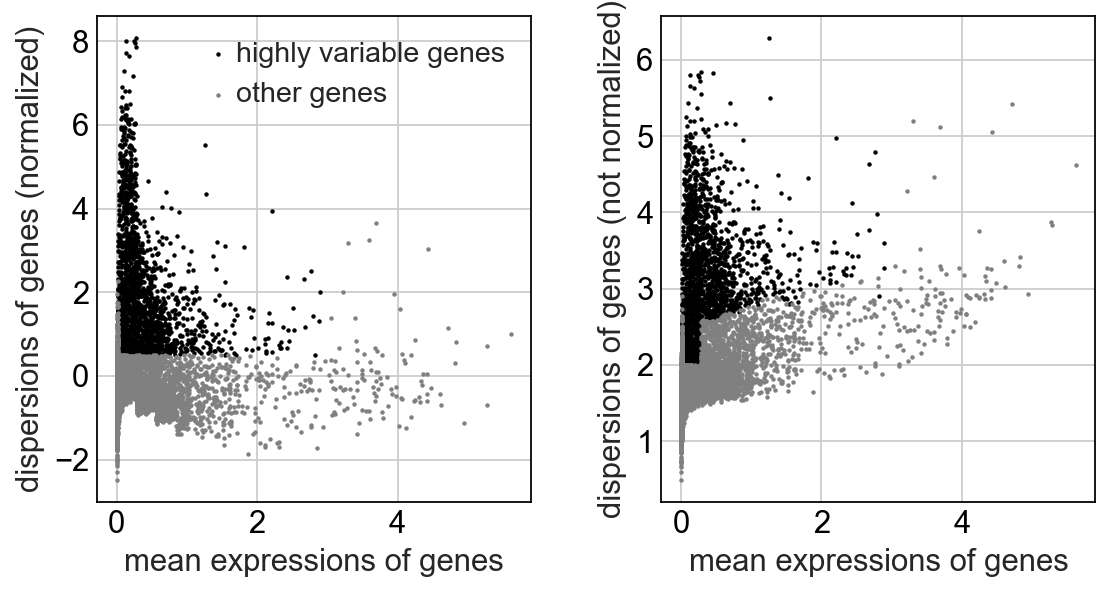

In [20]:
sc.pl.highly_variable_genes(adata)

Set the `.raw` attribute of the AnnData object to the normalized and logarithmized raw gene expression for later use in differential testing and visualizations of gene expression. This simply freezes the state of the AnnData object.

:::{note}
You can get back an `AnnData` of the object in `.raw` by calling `.raw.to_adata()`.
:::

In [21]:
adata.raw = adata

:::{note}
If you don't proceed below with correcting the data with `sc.pp.regress_out` and scaling it via `sc.pp.scale`, you can also get away without using `.raw` at all.

The result of the previous highly-variable-genes detection is stored as an annotation in `.var.highly_variable` and auto-detected by PCA and hence, `sc.pp.neighbors` and subsequent manifold/graph tools. In that case, the step *actually do the filtering* below is unnecessary, too.
:::

Actually do the filtering

In [22]:
adata = adata[:, adata.var.highly_variable]

Regress out effects of total counts per cell and the percentage of mitochondrial genes expressed. Scale the data to unit variance.

In [23]:
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])

regressing out ['total_counts', 'pct_counts_mt']
    sparse input is densified and may lead to high memory use
    finished (0:00:10)


Scale each gene to unit variance. Clip values exceeding standard deviation 10. 

In [24]:
sc.pp.scale(adata, max_value=10)

## Principal component analysis

Reduce the dimensionality of the data by running principal component analysis (PCA), which reveals the main axes of variation and denoises the data.

In [25]:
sc.tl.pca(adata, svd_solver='arpack')

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)


We can make a scatter plot in the PCA coordinates, but we will not use that later on.

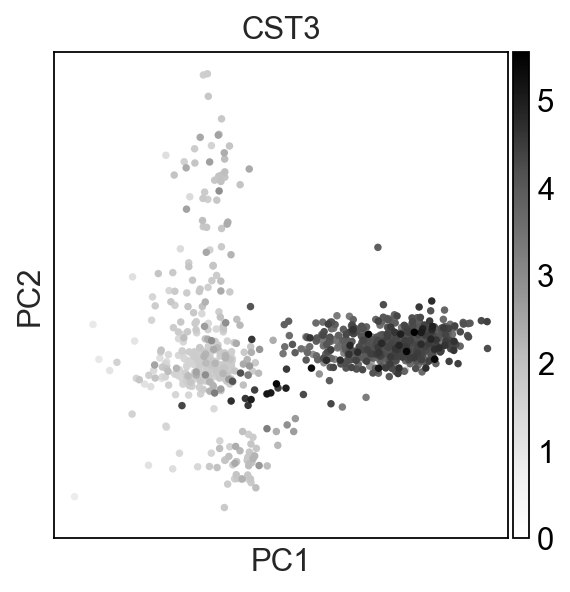

In [26]:
sc.pl.pca(adata, color='CST3')

Let us inspect the contribution of single PCs to the total variance in the data. This gives us information about how many PCs we should consider in order to compute the neighborhood relations of cells, e.g. used in the clustering function  `sc.tl.louvain()` or tSNE `sc.tl.tsne()`. In our experience, often a rough estimate of the number of PCs does fine.

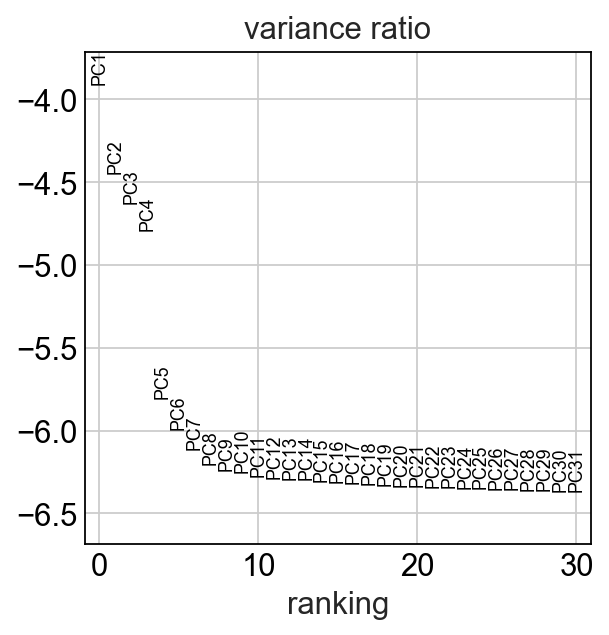

In [27]:
sc.pl.pca_variance_ratio(adata, log=True)

Save the result.

In [28]:
adata.write(results_file)

In [29]:
adata

AnnData object with n_obs × n_vars = 2638 × 1838
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

## Computing the neighborhood graph

Let us compute the neighborhood graph of cells using the PCA representation of the data matrix. You might simply use default values here. For the sake of reproducing Seurat's results, let's take the following values.

In [30]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)


## Embedding the neighborhood graph

We suggest embedding the graph in two dimensions using UMAP ([McInnes et al., 2018](https://arxiv.org/abs/1802.03426)), see below. It is potentially more faithful to the global connectivity of the manifold than tSNE, i.e., it better preserves trajectories. In some ocassions, you might still observe disconnected clusters and similar connectivity violations. They can usually be remedied by running:

```Python
sc.tl.paga(adata)
sc.pl.paga(adata, plot=False)  # remove `plot=False` if you want to see the coarse-grained graph
sc.tl.umap(adata, init_pos='paga')
```

In [31]:
sc.tl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:03)


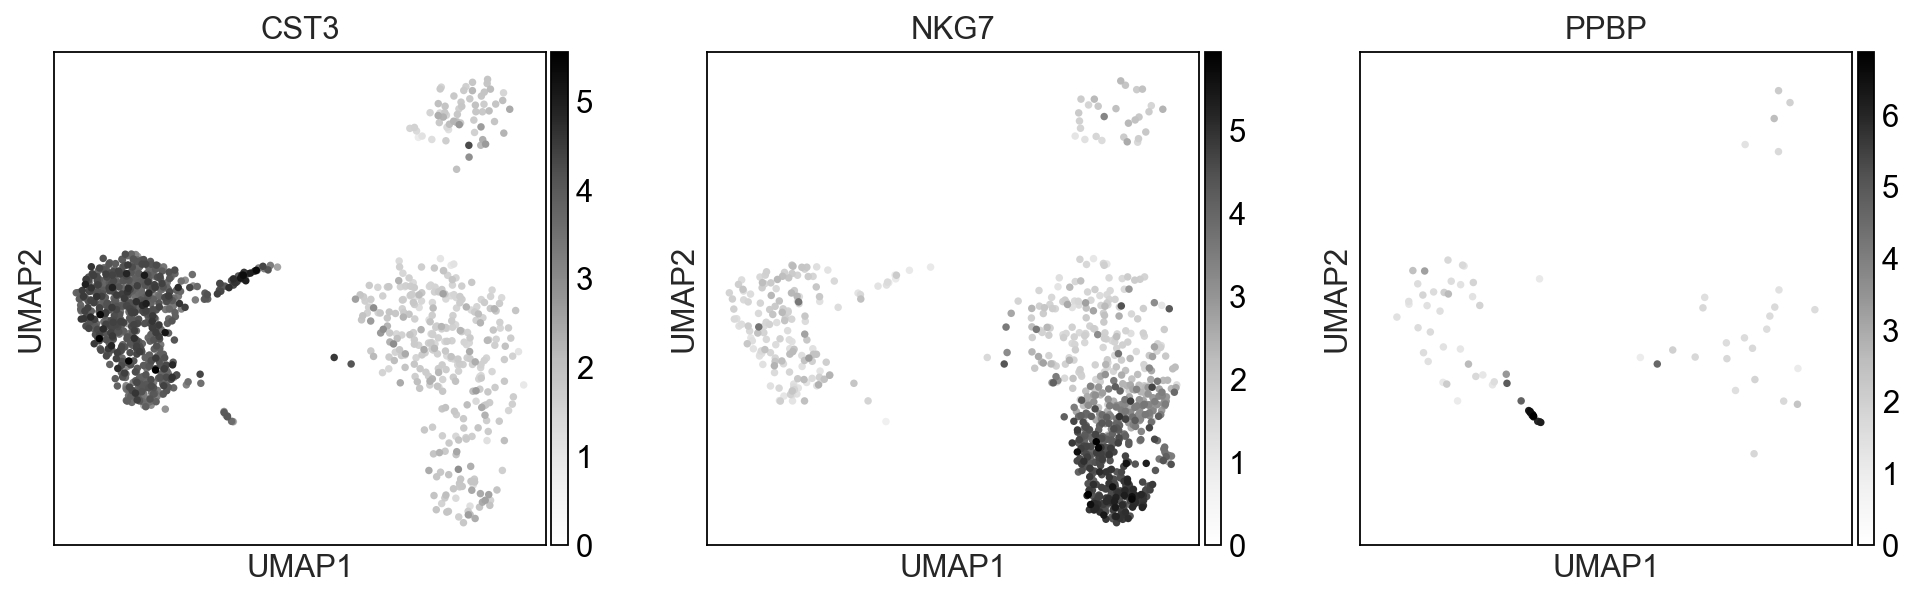

In [32]:
sc.pl.umap(adata, color=['CST3', 'NKG7', 'PPBP'])

As we set the `.raw` attribute of `adata`, the previous plots showed the "raw" (normalized, logarithmized, but uncorrected) gene expression. You can also plot the scaled and corrected gene expression by explicitly stating that you don't want to use `.raw`.

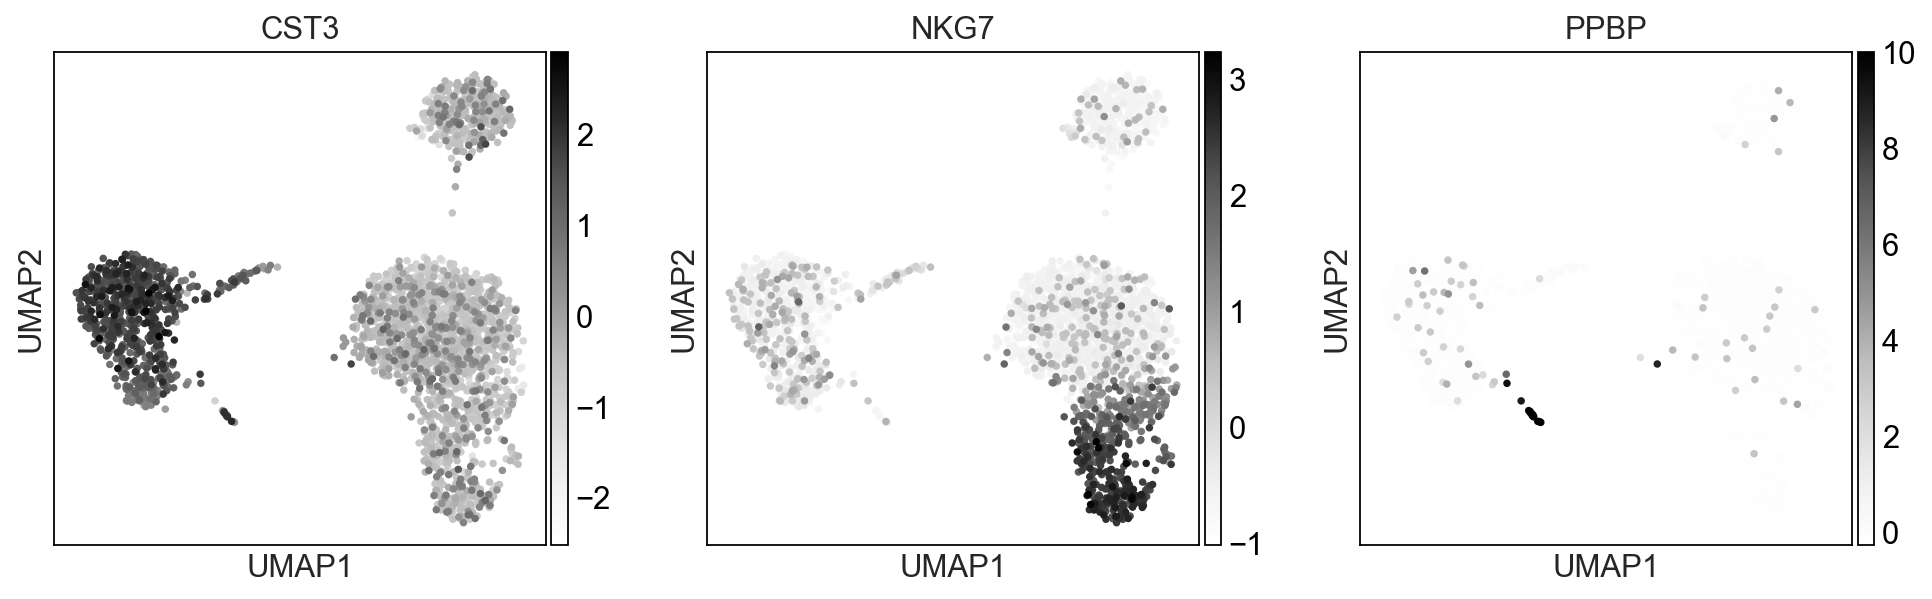

In [33]:
sc.pl.umap(adata, color=['CST3', 'NKG7', 'PPBP'], use_raw=False)

## Clustering the neighborhood graph

As with Seurat and many other frameworks, we recommend the Leiden graph-clustering method (community detection based on optimizing modularity) by [Traag *et al.* (2018)](https://scanpy.readthedocs.io/en/latest/references.html#traag18). Note that Leiden clustering directly clusters the neighborhood graph of cells, which we already computed in the previous section.

In [34]:
sc.tl.leiden(adata)

running Leiden clustering
    finished: found 8 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


Plot the clusters, which agree quite well with the result of Seurat.

/Users/yinglin/opt/anaconda3/envs/sc1/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


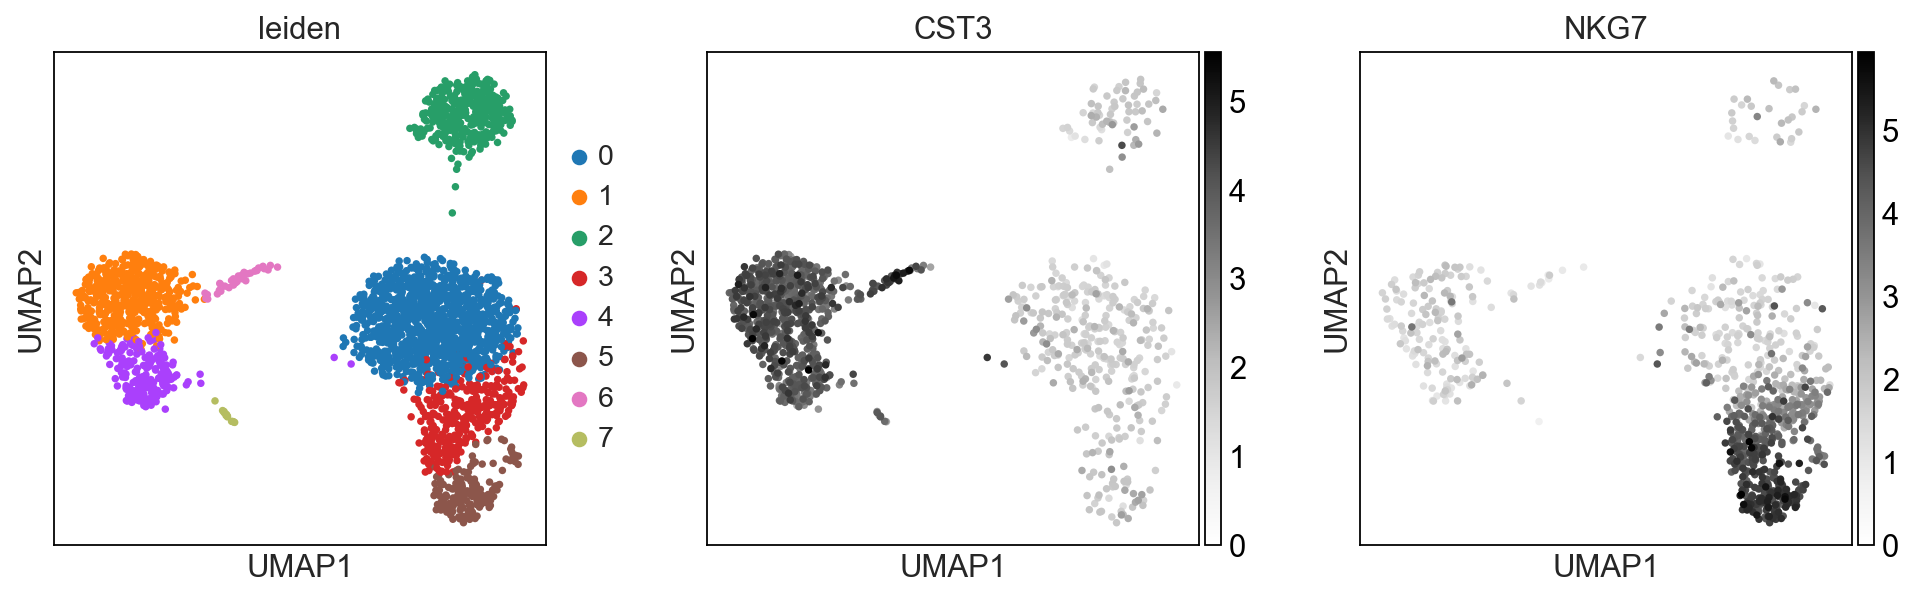

In [35]:
sc.pl.umap(adata, color=['leiden', 'CST3', 'NKG7'])

Save the result.

In [36]:
adata.write(results_file)

## Finding marker genes

Let us compute a ranking for the highly differential genes in each cluster. For this, by default, the `.raw` attribute of AnnData is used in case it has been initialized before. The simplest and fastest method to do so is the t-test.

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


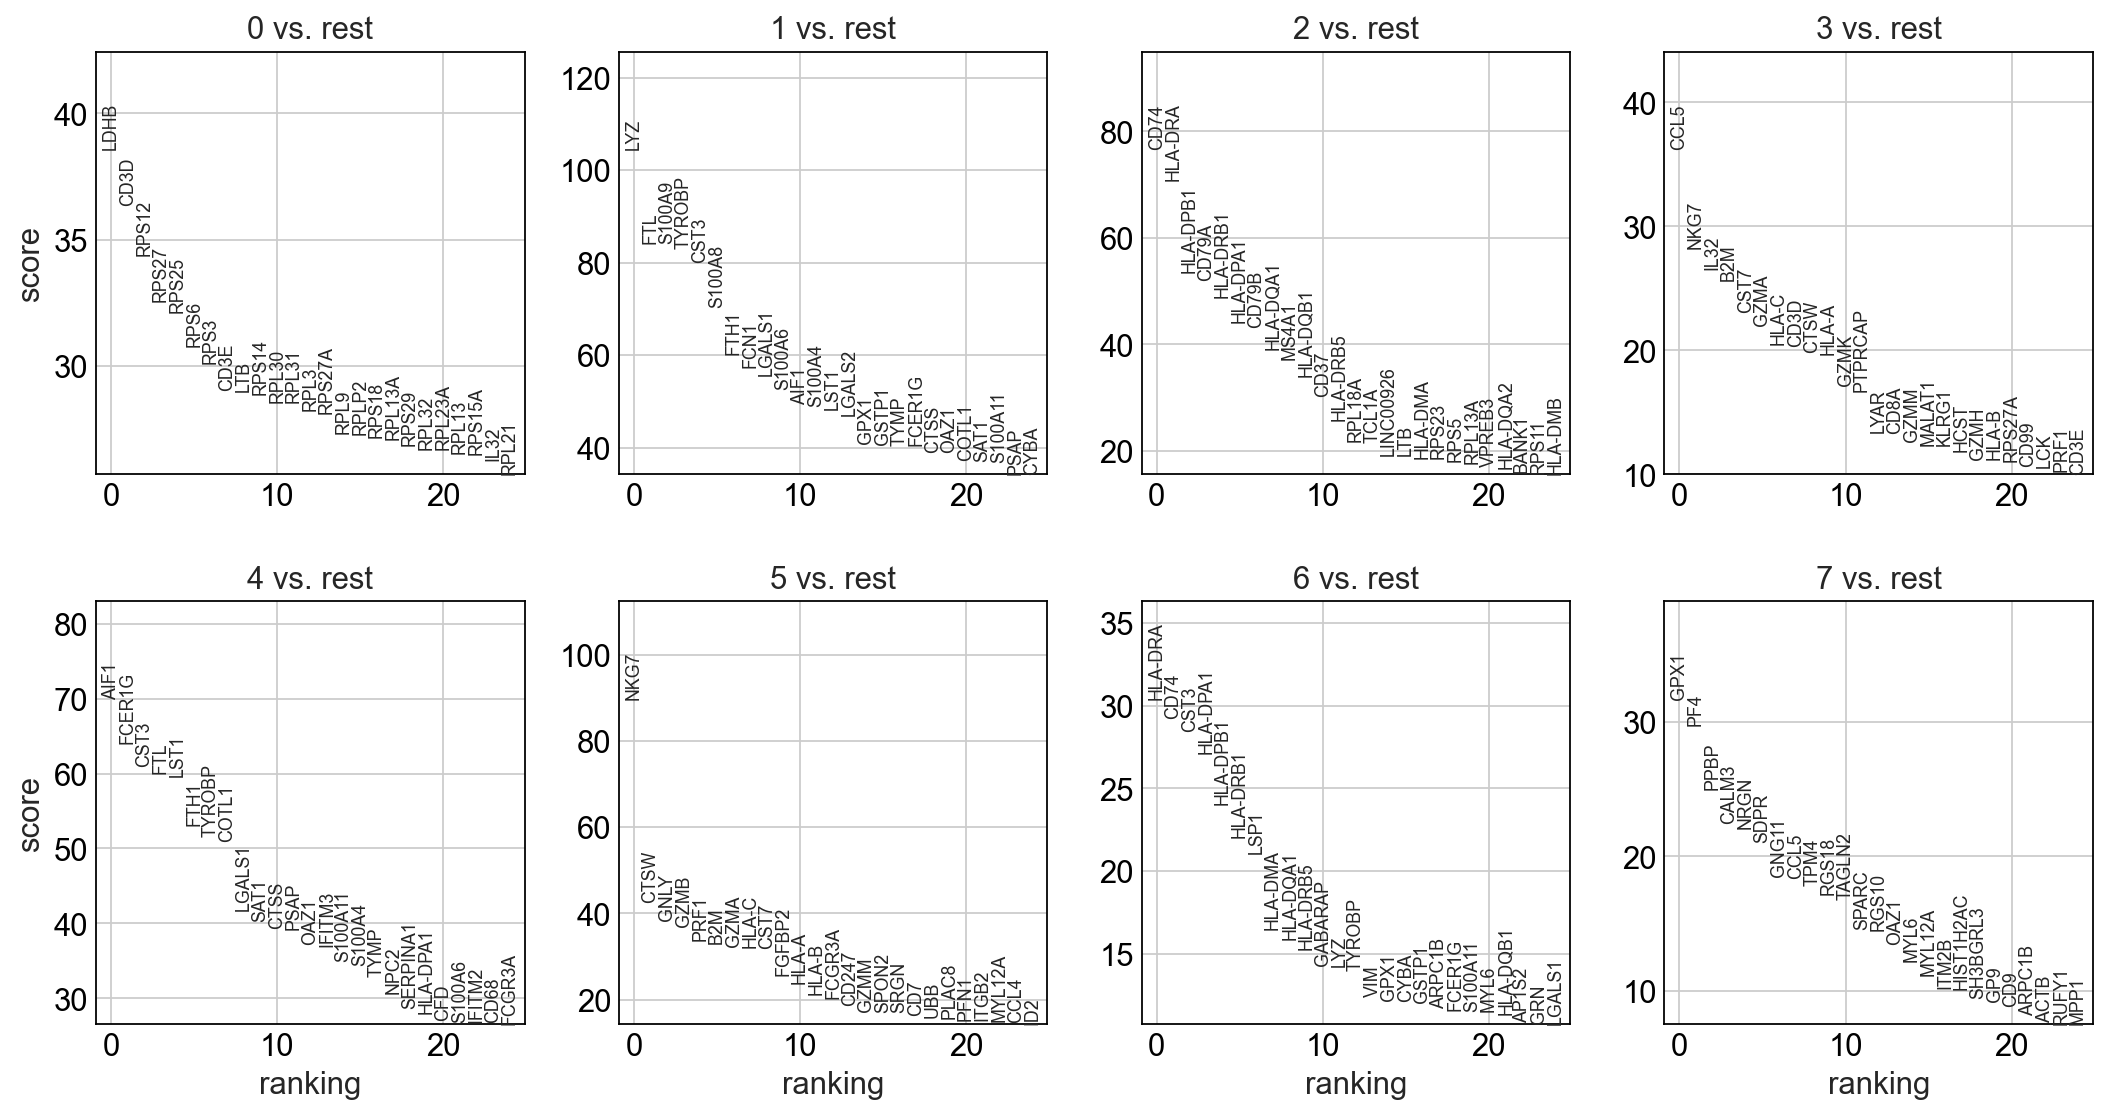

In [37]:
sc.tl.rank_genes_groups(adata, 'leiden', method='t-test')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [38]:
sc.settings.verbosity = 2  # reduce the verbosity

The result of a [Wilcoxon rank-sum (Mann-Whitney-U)](https://en.wikipedia.org/wiki/Mann%E2%80%93Whitney_U_test) test is very similar. We recommend using the latter in publications, see e.g., [Sonison & Robinson (2018)](https://doi.org/10.1038/nmeth.4612). You might also consider much more powerful differential testing packages like MAST, limma, DESeq2 and, for python, the recent diffxpy.

ranking genes
    finished (0:00:01)


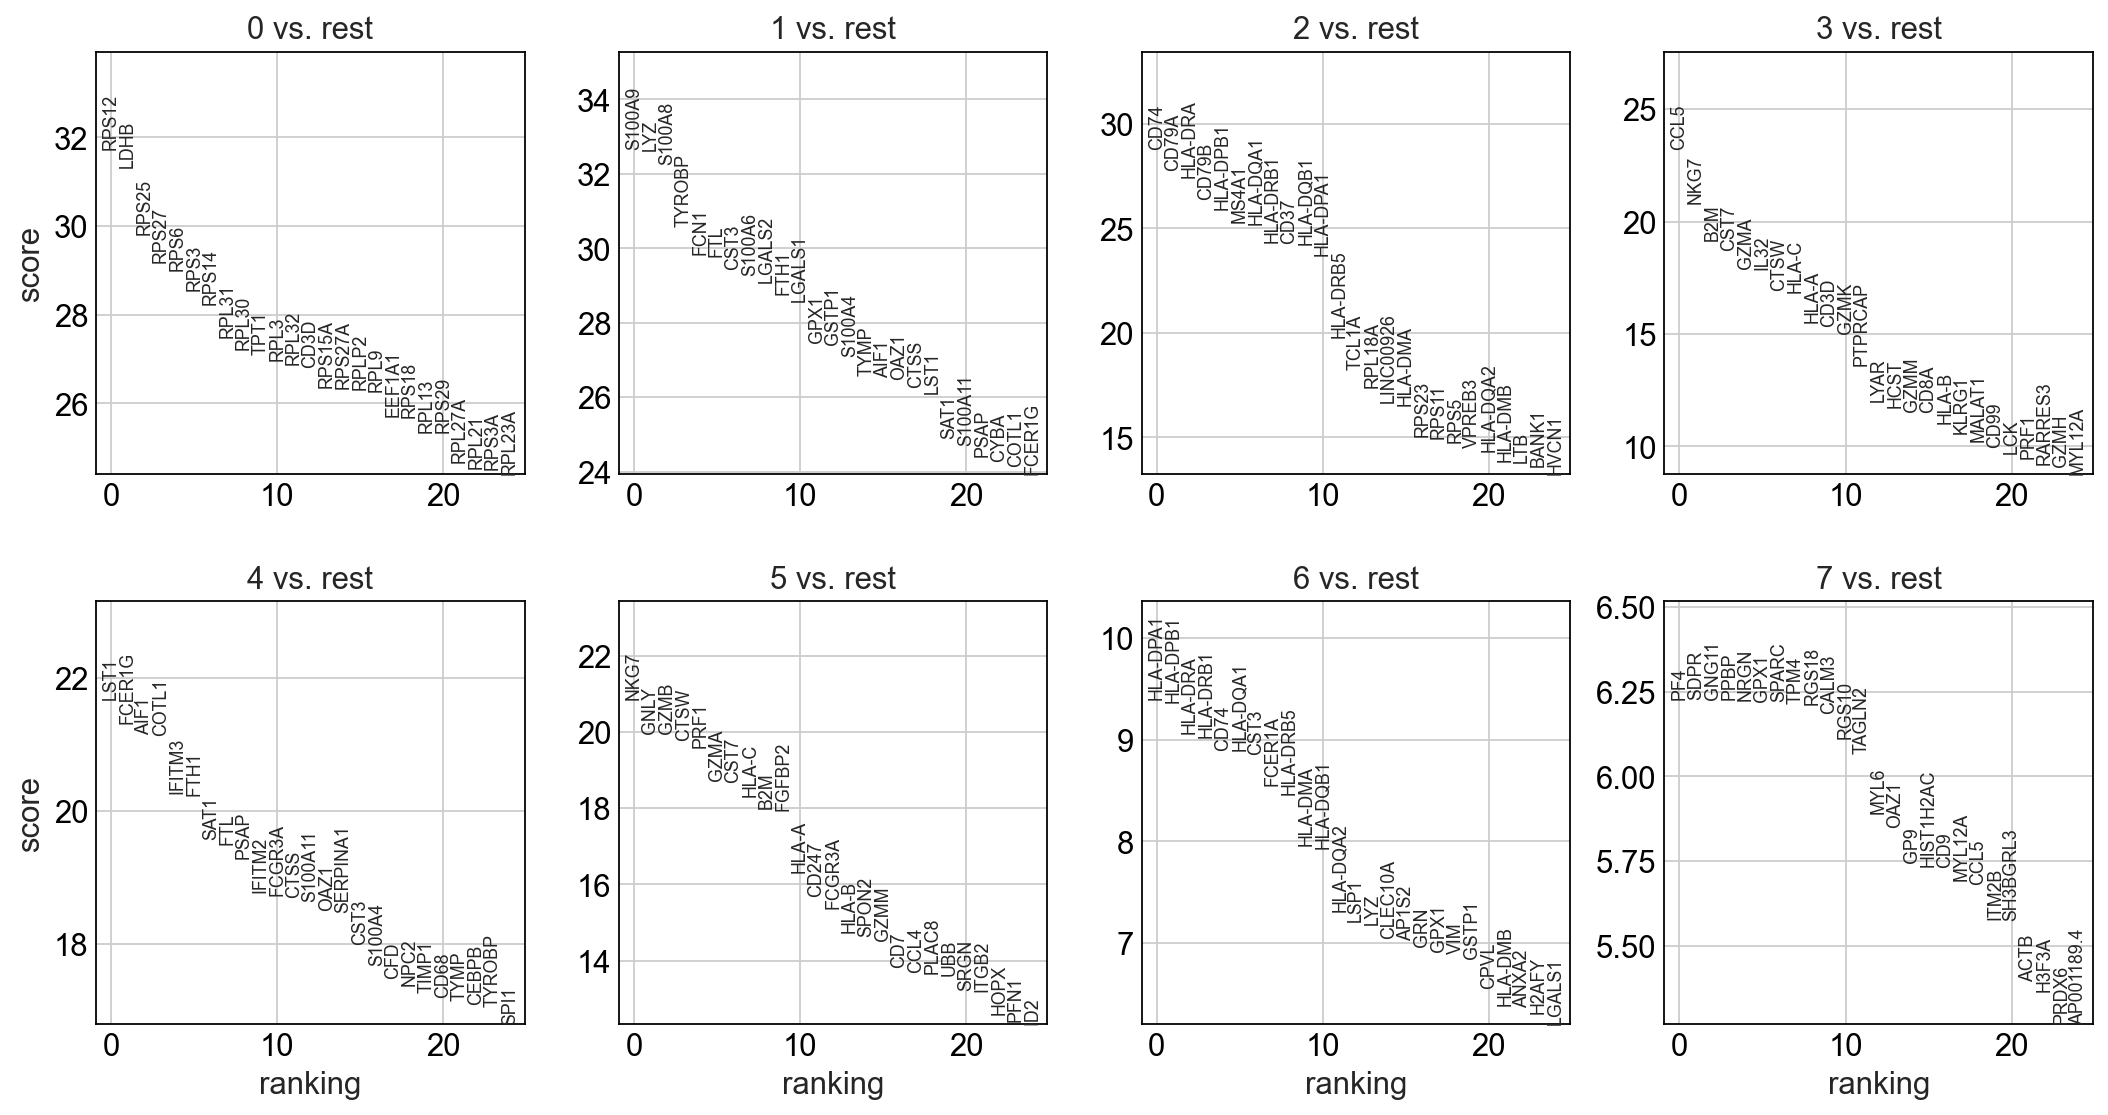

In [39]:
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

Save the result.

In [40]:
adata.write(results_file)

As an alternative, let us rank genes using logistic regression. For instance, this has been suggested by [Natranos et al. (2018)](https://doi.org/10.1101/258566). The essential difference is that here, we use a multi-variate appraoch whereas conventional differential tests are uni-variate. [Clark et al. (2014)](https://doi.org/10.1186/1471-2105-15-79) has more details.

ranking genes
    finished (0:00:03)


/Users/yinglin/opt/anaconda3/envs/sc1/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


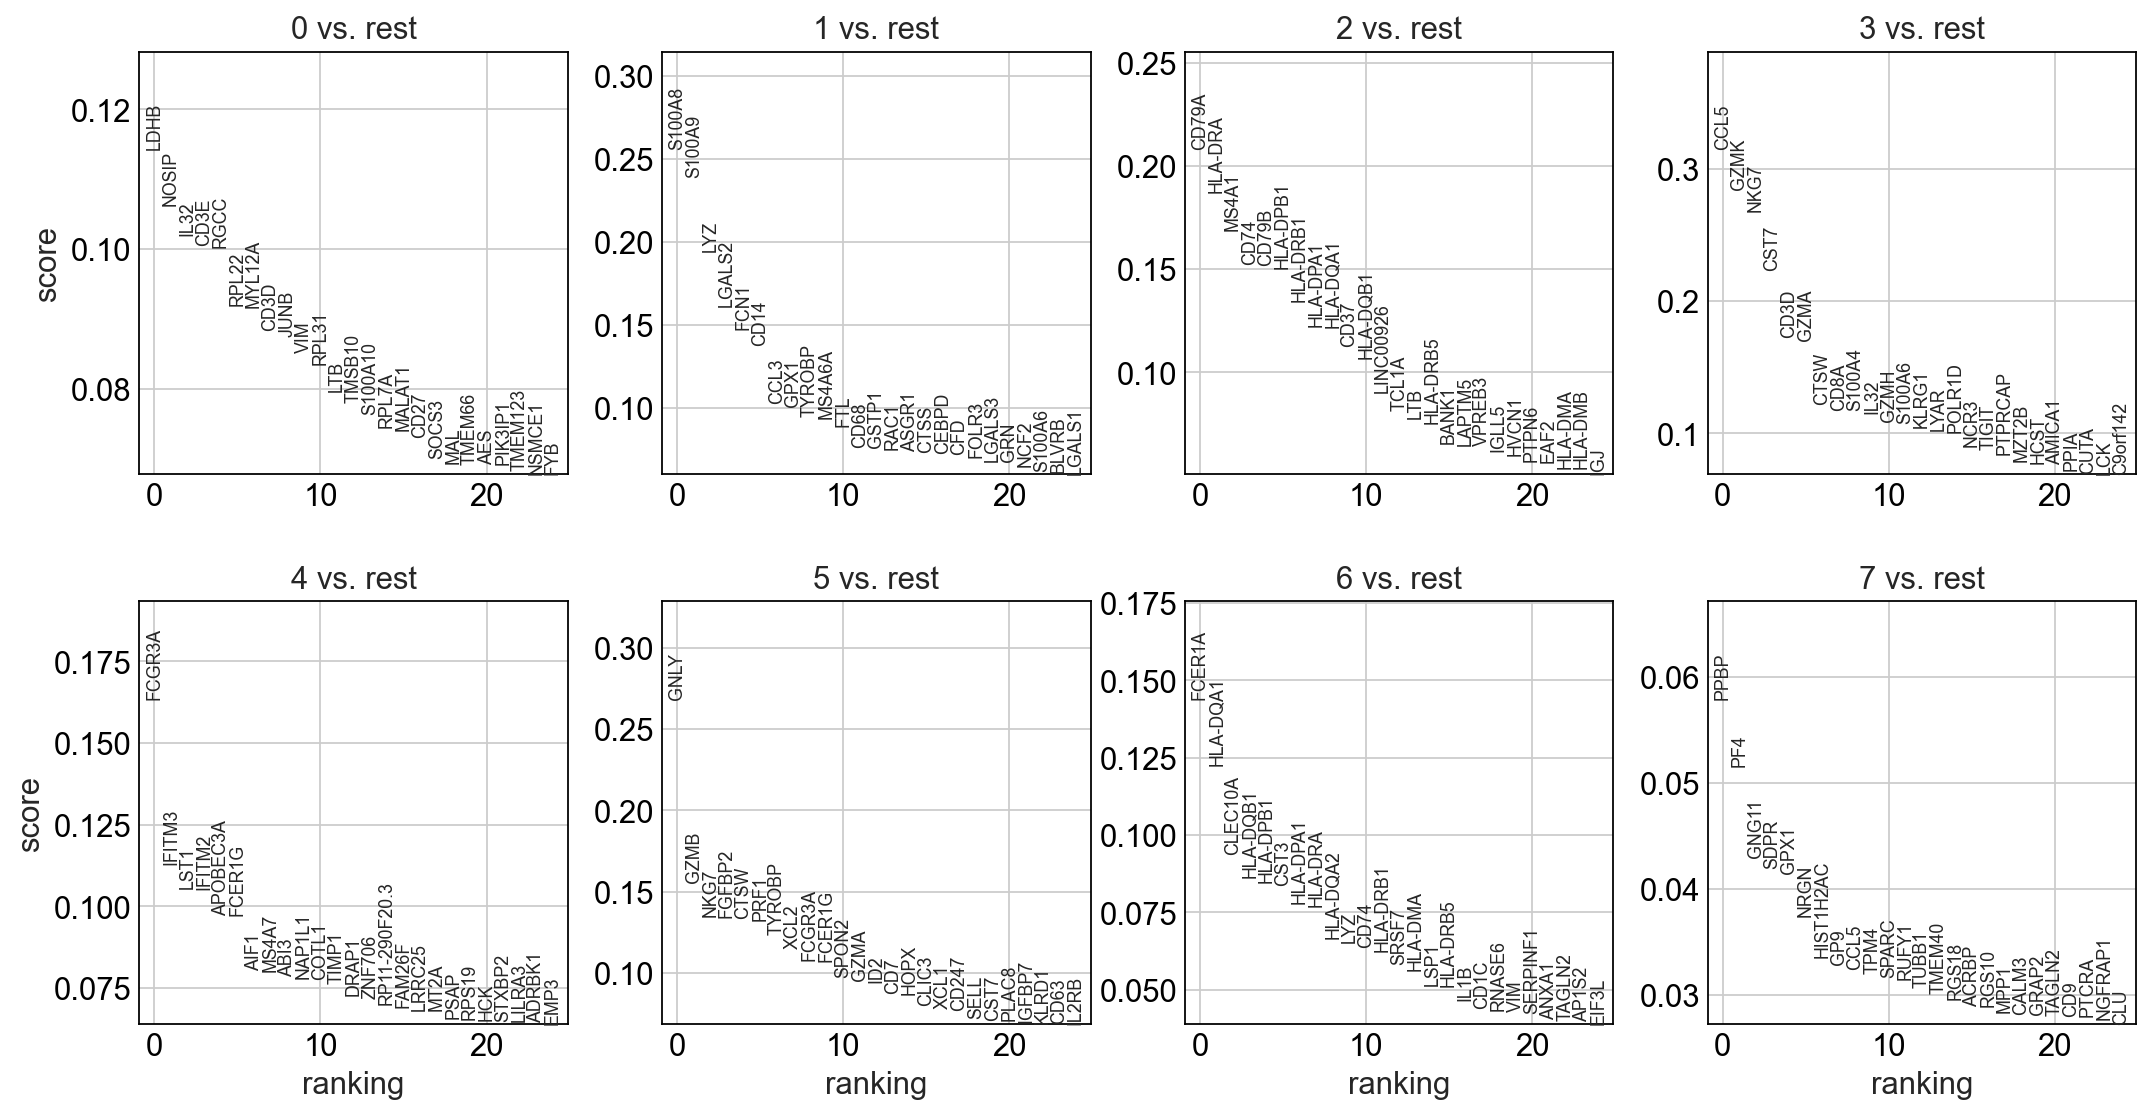

In [41]:
sc.tl.rank_genes_groups(adata, 'leiden', method='logreg')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

With the exceptions of *IL7R*, which is only found by the t-test and *FCER1A*, which is only found by the other two appraoches, all marker genes are recovered in all approaches.

Louvain Group | Markers | Cell Type
---|---|---
0 | IL7R | CD4 T cells
1 | CD14, LYZ | CD14+ Monocytes
2 | MS4A1 |	B cells
3 | CD8A |	CD8 T cells
4 | GNLY, NKG7 | 	NK cells
5 | FCGR3A, MS4A7 |	FCGR3A+ Monocytes
6 | FCER1A, CST3 |	Dendritic Cells
7 | PPBP |	Megakaryocytes

Let us also define a list of marker genes for later reference.

In [42]:
marker_genes = ['IL7R', 'CD79A', 'MS4A1', 'CD8A', 'CD8B', 'LYZ', 'CD14',
                'LGALS3', 'S100A8', 'GNLY', 'NKG7', 'KLRB1',  
                'FCGR3A', 'MS4A7', 'FCER1A', 'CST3', 'PPBP']

Reload the object that has been save with the Wilcoxon Rank-Sum test result.

In [43]:
adata = sc.read(results_file)

Show the 10 top ranked genes per cluster 0, 1, ..., 7 in a dataframe.

In [44]:
adata.uns_keys

<bound method AnnData.uns_keys of AnnData object with n_obs × n_vars = 2638 × 1838
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'>

In [45]:
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(5)

,0,1,2,3,4,5,6,7
0,RPS12,S100A9,CD74,CCL5,LST1,NKG7,HLA-DPA1,PF4
1,LDHB,LYZ,CD79A,NKG7,FCER1G,GNLY,HLA-DPB1,SDPR
2,RPS25,S100A8,HLA-DRA,B2M,AIF1,GZMB,HLA-DRA,GNG11
3,RPS27,TYROBP,CD79B,CST7,COTL1,CTSW,HLA-DRB1,PPBP
4,RPS6,FCN1,HLA-DPB1,GZMA,IFITM3,PRF1,CD74,NRGN


Get a table with the scores and groups.

In [46]:
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals']}).head(5)

,0_n,0_p,1_n,1_p,2_n,2_p,3_n,3_p,4_n,4_p,5_n,5_p,6_n,6_p,7_n,7_p
0,RPS12,4.969659e-221,S100A9,5.013557e-234,CD74,3.043536e-182,CCL5,2.806278e-119,LST1,2.733939e-104,NKG7,1.203971e-96,HLA-DPA1,5.422417e-21,PF4,4.722886e-10
1,LDHB,2.087877e-215,LYZ,1.276687e-233,CD79A,6.860832e-170,NKG7,2.261886e-96,FCER1G,8.235039e-101,GNLY,1.257170e-88,HLA-DPB1,7.591860e-21,SDPR,4.733899e-10
2,RPS25,1.825387e-195,S100A8,2.135223e-228,HLA-DRA,8.398068e-166,B2M,1.005467e-81,AIF1,2.582775e-99,GZMB,1.429027e-88,HLA-DRA,1.306768e-19,GNG11,4.733899e-10
3,RPS27,3.314940e-187,TYROBP,2.136387e-205,CD79B,1.171444e-153,CST7,3.708906e-78,COTL1,3.696354e-99,CTSW,4.144726e-87,HLA-DRB1,1.865104e-19,PPBP,4.744938e-10
4,RPS6,6.531859e-185,FCN1,8.605073e-196,HLA-DPB1,6.167786e-148,GZMA,6.528245e-72,IFITM3,2.486695e-91,PRF1,1.692100e-85,CD74,5.853161e-19,NRGN,4.800511e-10


In [47]:
adata.uns['rank_genes_groups']

{'logfoldchanges': array([( 1.0384423,  7.387613 ,  4.0653596 ,  5.100728  ,  5.1403584,  6.8891664,  4.2783146 , 12.905741 ),
        ( 2.6337495,  6.1882434,  7.7365117 ,  4.6226816 ,  4.7934203,  7.8330994,  4.4348464 , 11.863666 ),
        ( 1.1535721,  7.535118 ,  4.866796  ,  0.75637007,  4.8519297,  7.6746583,  4.6085496 , 12.428451 ),
        ...,
        (-4.3448286, -1.2175972, -3.1377041 , -1.0711807 , -0.9695601, -1.0397398, -0.7930738 , -5.350221 ),
        (-2.0566492, -2.021143 , -0.85972863, -0.7454294 , -1.0387655, -1.2977405, -0.77232665, -3.9652784),
        (-2.8188772, -1.6010815, -3.8895817 , -0.63358825, -1.2265491, -1.2602488, -1.1790817 , -4.8402567)],
       dtype=[('0', '<f4'), ('1', '<f4'), ('2', '<f4'), ('3', '<f4'), ('4', '<f4'), ('5', '<f4'), ('6', '<f4'), ('7', '<f4')]),
 'names': array([('RPS12', 'S100A9', 'CD74', 'CCL5', 'LST1', 'NKG7', 'HLA-DPA1', 'PF4'),
        ('LDHB', 'LYZ', 'CD79A', 'NKG7', 'FCER1G', 'GNLY', 'HLA-DPB1', 'SDPR'),
        ('RPS25',

Compare to a single cluster: 

ranking genes
    finished (0:00:00)


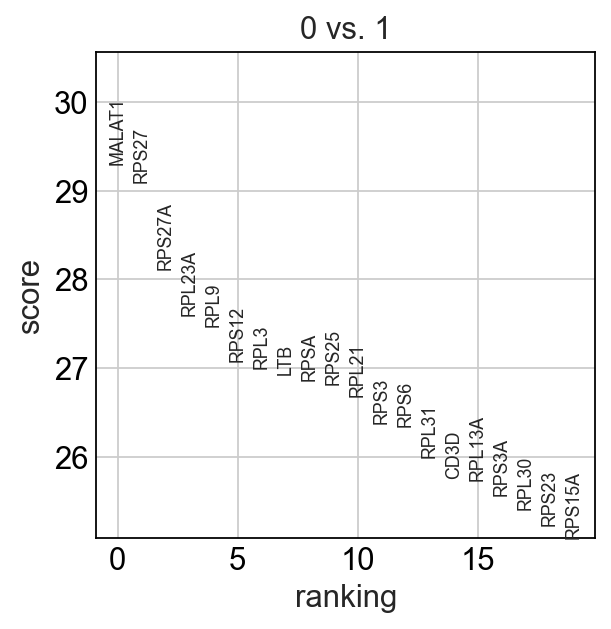

In [48]:
# workaround to fix scanpy bug
# from https://github.com/scverse/scanpy/issues/2181
adata.uns['log1p']["base"] = None
sc.tl.rank_genes_groups(adata, 'leiden', groups=['0'], reference='1', method='wilcoxon')
sc.pl.rank_genes_groups(adata, groups=['0'], n_genes=20)

In [49]:
#sc.tl.rank_genes_groups(adata, 'leiden', groups=['0'], reference='1', method='wilcoxon')
#sc.pl.rank_genes_groups(adata, groups=['0'], n_genes=20)

If we want a more detailed view for a certain group, use `sc.pl.rank_genes_groups_violin`.

/Users/yinglin/opt/anaconda3/envs/sc1/lib/python3.10/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)


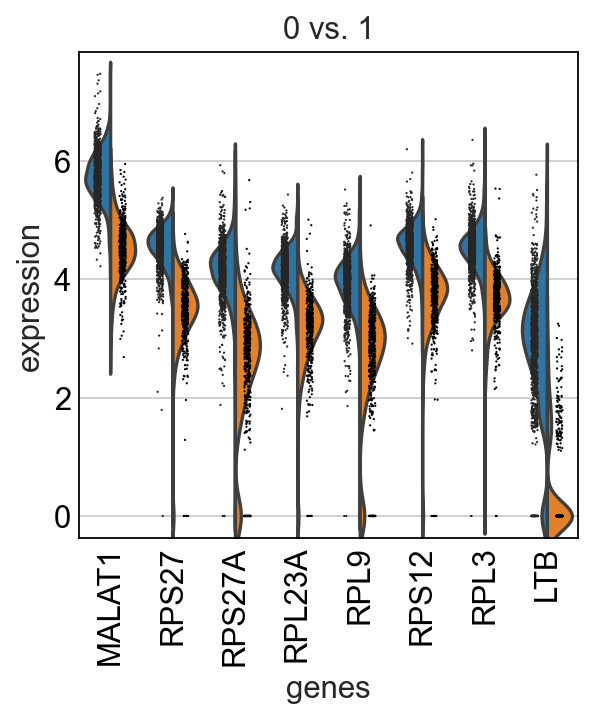

In [50]:
sc.pl.rank_genes_groups_violin(adata, groups='0', n_genes=8)

Reload the object with the computed differential expression (i.e. DE via a comparison with the rest of the groups):

In [51]:
adata = sc.read(results_file)

In [52]:
#adata.uns_keys

In [53]:
#adata.uns['gene_ids']

/Users/yinglin/opt/anaconda3/envs/sc1/lib/python3.10/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)


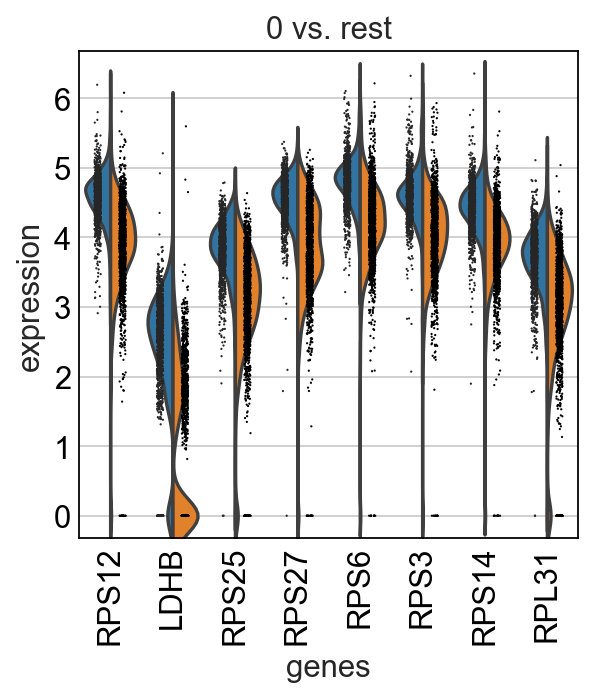

In [54]:
sc.pl.rank_genes_groups_violin(adata, groups='0', n_genes=8)

If you want to compare a certain gene across groups, use the following.

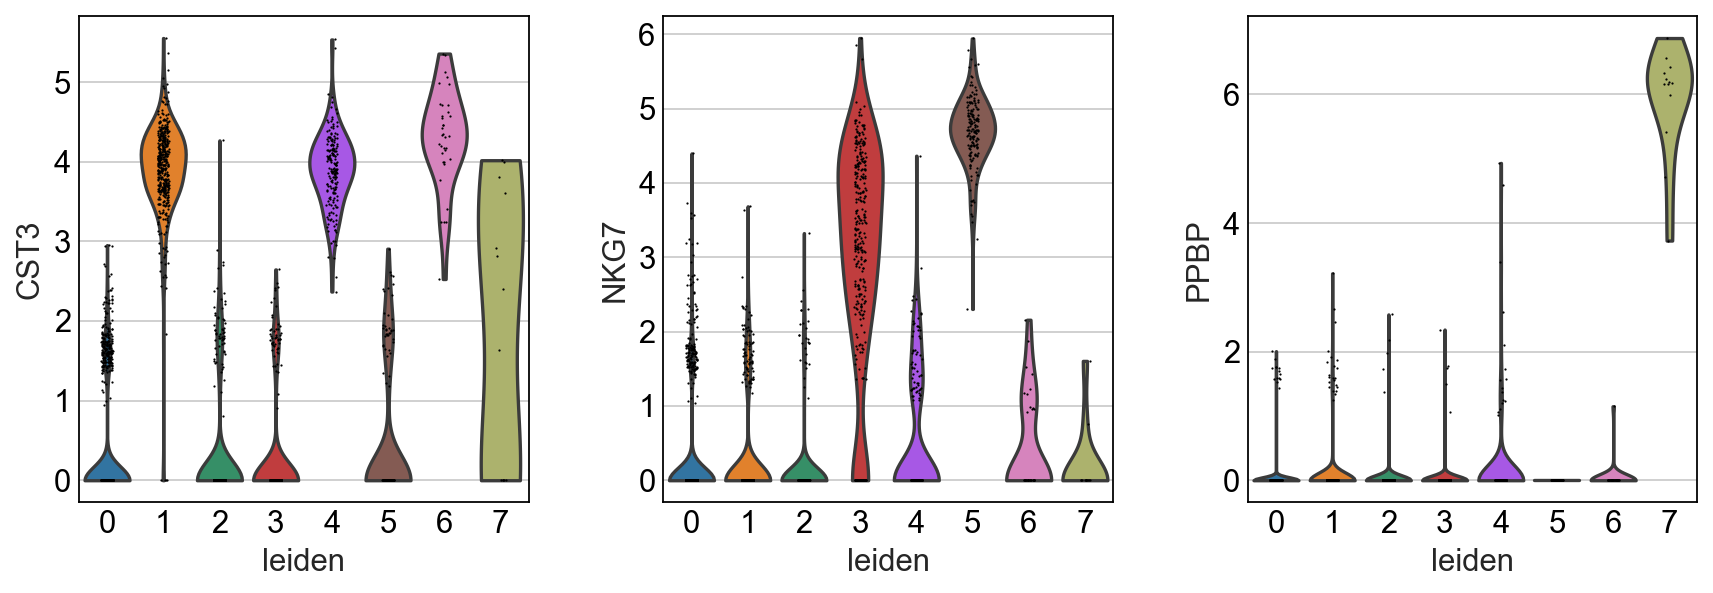

In [55]:
sc.pl.violin(adata, ['CST3', 'NKG7', 'PPBP'], groupby='leiden')

Actually mark the cell types.

In [56]:
new_cluster_names = [
    'CD4 T', 'CD14 Monocytes',
    'B', 'CD8 T', 
    'NK', 'FCGR3A Monocytes',
    'Dendritic', 'Megakaryocytes']
adata.rename_categories('leiden', new_cluster_names)

/Users/yinglin/opt/anaconda3/envs/sc1/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


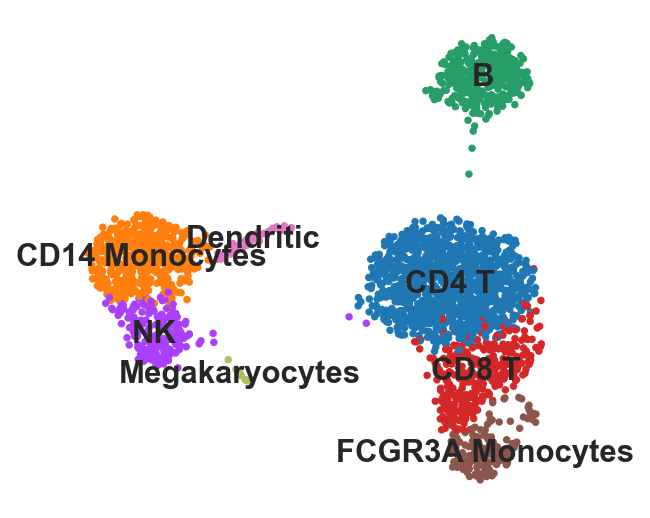

In [57]:
sc.pl.umap(adata, color='leiden', legend_loc='on data', title='', frameon=False, save='.pdf')

Now that we annotated the cell types, let us visualize the marker genes.

/Users/yinglin/opt/anaconda3/envs/sc1/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


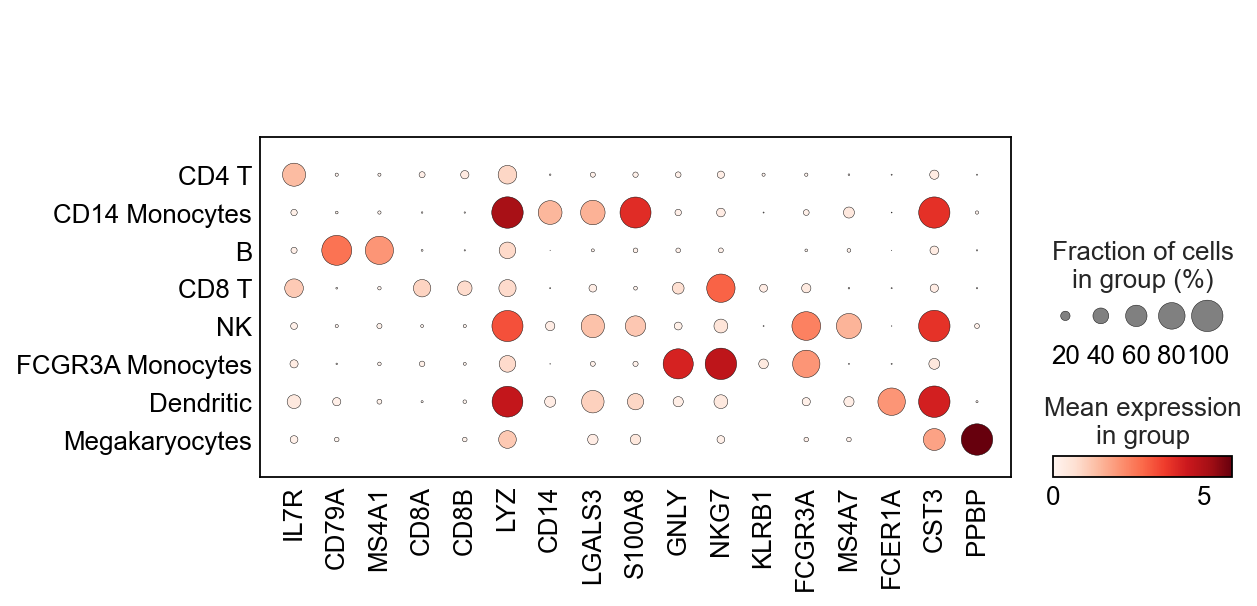

In [58]:
sc.pl.dotplot(adata, marker_genes, groupby='leiden');

There is also a very compact violin plot.

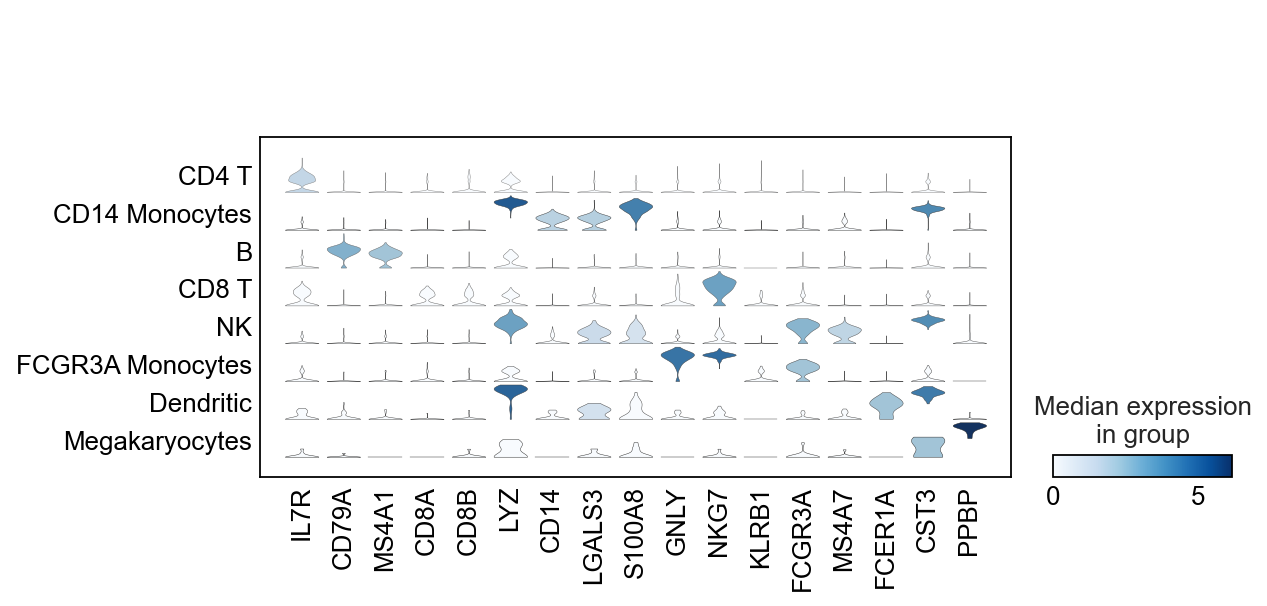

In [59]:
sc.pl.stacked_violin(adata, marker_genes, groupby='leiden', rotation=90);

During the course of this analysis, the AnnData accumlated the following annotations.

In [60]:
adata

AnnData object with n_obs × n_vars = 2638 × 1838
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [61]:
adata.write(results_file, compression='gzip')  # `compression='gzip'` saves disk space, but slows down writing and subsequent reading

Get a rough overview of the file using `h5ls`, which has many options - for more details see [here](https://github.com/theislab/scanpy_usage/blob/master/170505_seurat/info_h5ad.md). The file format might still be subject to further optimization in the future. All reading functions will remain backwards-compatible, though.

If you want to share this file with people who merely want to use it for visualization, a simple way to reduce the file size is by removing the dense scaled and corrected data matrix. The file still contains the raw data used in the visualizations in `adata.raw`.

In [62]:
adata.raw.to_adata().write('./write/pbmc3k_withoutX.h5ad')

If you want to export to "csv", you have the following options:

In [63]:
# Export single fields of the annotation of observations
# adata.obs[['n_counts', 'louvain_groups']].to_csv(
#     './write/pbmc3k_corrected_louvain_groups.csv')

# Export single columns of the multidimensional annotation
# adata.obsm.to_df()[['X_pca1', 'X_pca2']].to_csv(
#     './write/pbmc3k_corrected_X_pca.csv')

# Or export everything except the data using `.write_csvs`.
# Set `skip_data=False` if you also want to export the data.
# adata.write_csvs(results_file[:-5], )